In [82]:
%load_ext jupyternotify
from pytket import Circuit, Qubit, Bit, OpType
from pytket.utils.operators import QubitPauliOperator
from sympy import symbols
from openfermion import QubitOperator
from random import sample
import numpy as np
# from pytket.backends.projectq import ProjectQBackend
from pytket.backends.ibm import AerStateBackend, AerBackend, AerUnitaryBackend, IBMQBackend
from scipy.linalg import expm, sinm, cosm
from sympy.physics.quantum.dagger import Dagger
import functools
import operator
import itertools    
from openfermion import get_sparse_operator
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt


def fidelity(rsv, gsv): 
    
    #rsv = real state vector 
    #gsv = generated statev vector 
    
    # rsv_conj = np.conj(rsv)
    # fid = sum(rsv_conj*gsv) * np.conj(sum(rsv_conj*gsv))
    
    return abs(np.vdot(rsv, gsv).real)

#constants 
n = 1 #number of qubits 
lamb = np.float(2)
s = np.exp(-1 / (2 * lamb)) - 1
cst1 = (s / 2 + 1) ** 2
cst2 = (s / 2) * (s / 2 + 1)
cst3 = (s / 2) ** 2

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [40]:
def real(n, weights):
    
    real_circ = Circuit()
    qubits = real_circ.add_q_register('q', n)

    real_circ.Rx(weights[0], qubits[0])
        
    real_circ.Ry(weights[1], qubits[0])
        
    real_circ.Rz(weights[2], qubits[0])
        

    # backend.compile_circuit(real_circ)
    # statevector = backend.get_state(real_circ)
    
    # return real_circ, statevector
    return real_circ


In [47]:
def generator(n, weights):
    
    generator_circ = Circuit()
    qubits = generator_circ.add_q_register('q', n)

    generator_circ.Rx(weights[0], qubits[0])

    generator_circ.Ry(weights[1], qubits[0])

    generator_circ.Rz(weights[2], qubits[0])
        
    # backend.compile_circuit(generator_circ)
    # statevector = backend.get_state(generator_circ)
    
    # return generator_circ, statevector
    return generator_circ


def generator_symbolic(n):
    
    generator_circ = Circuit()
    qubits = generator_circ.add_q_register('q', n)
    weight_symbols = symbols([f'theta_{i}' for i in range(3)])

    generator_circ.Rx(weight_symbols[0], qubits[0])

    generator_circ.Ry(weight_symbols[1], qubits[0])

    generator_circ.Rz(weight_symbols[2], qubits[0])
        
    # backend.compile_circuit(generator_circ)
    # statevector = backend.get_state(generator_circ)
    
    # return generator_circ, statevector
    return generator_circ,weight_symbols


In [77]:
def operator_inner(left, operator_matrix, right):
    return np.vdot(left, operator_matrix.dot(right))

In [75]:
class Discriminator:
    def __init__(self, init_weights):
        # self.backend = _backend
        self.weights = init_weights
    def set_weights(self, _weights):
        self.weights = _weights
    def get_operators(self):
        disc_weights = self.weights
        #creates the hermitian operators phi and psi 
        disc_weights_phi = disc_weights[:len(disc_weights)//2]
        disc_weights_psi = disc_weights[len(disc_weights)//2:]

        tuple_list_phi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_phi, itertools.product(['X', 'Y', 'Z'], range(n)))]
        tuple_list_psi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_psi, itertools.product(['X', 'Y', 'Z'], range(n)))]

        measurements_phi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_phi))
        measurements_psi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_psi))

        iden_phi =  functools.reduce(operator.add, ( (disc_weights_phi[len(disc_weights_phi)-1] ) * QubitOperator(" ") ))
        iden_psi =  functools.reduce(operator.add, ( (disc_weights_psi[len(disc_weights_psi)-1]) * QubitOperator(" ") ))

        phi = operator.add(iden_phi, measurements_phi)
        psi = operator.add(iden_psi, measurements_psi)

        return (psi, phi)

    def calculate_loss(self, real_sv, gen_sv):
        # for c in (_real_circ, _gen_circ):
        #     self.backend.compile_circuit(c)
        # real_sv = self.backend.get_state(real_circ)
        # gen_sv = self.backend.get_state(gen_circ)

        psi, phi = self.get_operators()
        #convert phi and psi operators to matrix 
        psi_matrix = np.array(get_sparse_operator(psi).todense())
        phi_matrix = np.array(get_sparse_operator(phi).todense())
        
        #calculate expectation values 
        
        psi_exp = operator_inner(real_sv, psi_matrix, real_sv)
        phi_exp = operator_inner(gen_sv, phi_matrix, gen_sv)

        # psi_exp = backend.get_operator_expectation_value(real_circ, QubitPauliOperator.from_OpenFermion(psi))
        # phi_exp = backend.get_operator_expectation_value(gen_circ, QubitPauliOperator.from_OpenFermion(phi)) 

        #calculate values for A and B which go into the calculation for the regterm
        A = expm(np.float(-1 / lamb) * phi_matrix)
        B = expm(np.float(1 / lamb) * psi_matrix)

        term1 = operator_inner(gen_sv, A, gen_sv)
        term2 = operator_inner(real_sv, B, real_sv)
        term3 = operator_inner(gen_sv, B, real_sv)
        term4 = operator_inner(real_sv, A, gen_sv)
        term5 = operator_inner(gen_sv, A, real_sv)
        term6 = operator_inner(real_sv, B, gen_sv)
        term7 = operator_inner(gen_sv, B, gen_sv)
        term8 = operator_inner(real_sv, A, real_sv)

        regterm = (lamb / np.e * (cst1 * term1 * term2 - cst2 * term3 * term4 - cst2 * term5 * term6 + cst3 * term7 * term8)).item()

        return np.real(psi_exp - phi_exp - regterm) 
    
    

In [71]:
def discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv):
    
    #creates the hermitian operators phi and psi 
    disc_weights_phi = disc_weights[:len(disc_weights)//2]
    disc_weights_psi = disc_weights[len(disc_weights)//2:]

    tuple_list_phi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_phi, itertools.product(['X', 'Y', 'Z'], range(n)))]
    tuple_list_psi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_psi, itertools.product(['X', 'Y', 'Z'], range(n)))]

    measurements_phi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_phi))
    measurements_psi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_psi))

    iden_phi =  functools.reduce(operator.add, ( (disc_weights_phi[len(disc_weights_phi)-1] ) * QubitOperator(" ") ))
    iden_psi =  functools.reduce(operator.add, ( (disc_weights_psi[len(disc_weights_psi)-1]) * QubitOperator(" ") ))

    phi = operator.add(iden_phi, measurements_phi)
    psi = operator.add(iden_psi, measurements_psi)

    #convert phi and psi operators to matrix 
    psi_matrix = np.array(get_sparse_operator(psi).todense())
    phi_matrix = np.array(get_sparse_operator(phi).todense())
    

    #calculate expectation values 
    psi_exp = backend.get_operator_expectation_value(real_circ, QubitPauliOperator.from_OpenFermion(psi))
    phi_exp = backend.get_operator_expectation_value(gen_circ, QubitPauliOperator.from_OpenFermion(phi)) 

    #calculate values for A and B which go into the calculation for the regterm
    A = expm(np.float(-1 / lamb) * phi_matrix)
    B = expm(np.float(1 / lamb) * psi_matrix)

    term1 = np.matmul(Dagger(gen_sv) , np.matmul(A, gen_sv))
    term2 = np.matmul(Dagger(real_sv), np.matmul(B,real_sv))
    term3 = np.matmul(Dagger(gen_sv), np.matmul(B,real_sv))
    term4 = np.matmul(Dagger(real_sv), np.matmul(A,gen_sv))
    term5 = np.matmul(Dagger(gen_sv), np.matmul(A,real_sv))
    term6 = np.matmul(Dagger(real_sv), np.matmul(B,gen_sv))
    term7 = np.matmul(Dagger(gen_sv), np.matmul(B,gen_sv))
    term8 = np.matmul(Dagger(real_sv), np.matmul(A,real_sv))

    regterm = (lamb / np.e * (cst1 * term1 * term2 - cst2 * term3 * term4 - cst2 * term5 * term6 + cst3 * term7 * term8)).item()

    return psi_exp , phi_exp , regterm
    


In [57]:
def make_disc_loss(real_state, gen_state):
    def disc_loss(disc_weights):
        disc = Discriminator(disc_weights)
        # psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
        # loss = np.real(psi_exp - phi_exp - regterm) 
        
        return -disc.calculate_loss(real_state, gen_state)
    return disc_loss

def make_gen_loss(base_circuit, symb_weights, real_state, backend, discriminator):
    
    def gen_loss(gen_weights):
        gen_circ = base_circuit.copy()
        gen_circ.symbol_substitution(dict(zip(symb_weights, gen_weights)))
        gen_state = backend.get_state(gen_circ)
        return discriminator.calculate_loss(real_state, gen_state)


    return gen_loss



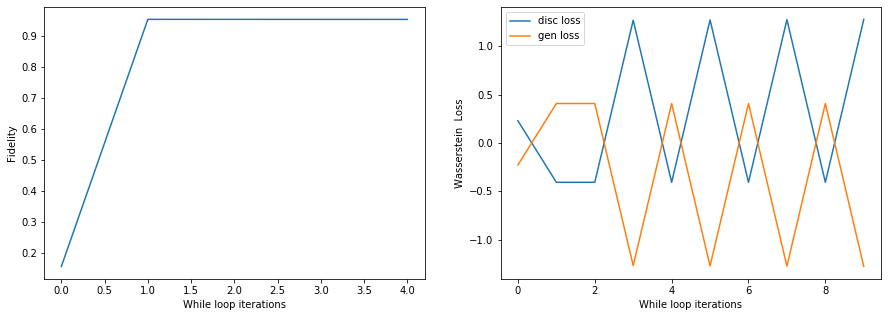

<IPython.core.display.Javascript object>

CPU times: user 5.75 s, sys: 3.23 s, total: 8.98 s
Wall time: 4.63 s


In [85]:
%%time
%%notify

backend = AerStateBackend()
gen_circ_base, symbolic_weights = generator_symbolic(n)
backend.compile_circuit(gen_circ_base)
np.random.seed(3)

for r in range(1):
    
    #generate a random real state and a initial fake state and the disc params 
    real_weights = np.random.uniform(0,2,3) 
    init_gen_weights = np.random.uniform(0,2,3)
    init_disc_weights = np.random.uniform(0,2,8)
    



    real_circ = real(n, real_weights)
    backend.compile_circuit(real_circ)
    real_sv = backend.get_state(real_circ)

    gen_circ = gen_circ_base.copy()
    gen_circ.symbol_substitution(dict(zip(symbolic_weights, init_gen_weights)))
    gen_sv = backend.get_state(gen_circ)
    init_fid = fidelity(real_sv, gen_sv)

    # fid = init_fid


    # dloss = []
    gloss = []
    f = []
    
    # f.append(init_fid)
    # dloss.append(disc_loss(init_disc_weights))
    # gloss.append(gen_loss(init_gen_weights))

    curr_gen_weights = init_gen_weights
    curr_disc_weights = init_disc_weights
    niter = 0 
    while fid <0.99:

        #calculate the updated gen circ and statevector 
        curr_gen_circ = gen_circ_base.copy()
        curr_gen_circ.symbol_substitution(dict(zip(symbolic_weights, curr_gen_weights)))
        
        fid = fidelity(real_sv, backend.get_state(curr_gen_circ))

        f.append(fid)

        #maximise loss for disc
        disc_loss = make_disc_loss(real_sv, gen_sv)
        gloss.append(-disc_loss(curr_disc_weights))

        disc_result = minimize(disc_loss, curr_disc_weights, method='Powell',  options={ 'maxiter': 300})
        curr_disc_weights = disc_result.x
        curr_disc = Discriminator(curr_disc_weights)
        # dloss.append(float(disc_result.fun))

        #minimise loss for gen
        gen_loss = make_gen_loss(gen_circ_base, symbolic_weights, real_sv, backend, curr_disc)
        gloss.append(gen_loss(curr_gen_weights))

        gen_result = minimize(gen_loss, curr_gen_weights, method='Powell', options={ 'maxiter': 300})
        curr_gen_weights = gen_result.x
        # gloss.append(float(gen_result.fun))
        

        niter += 1

        if niter == 5:
            break 

            
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))


    y = np.real(f)
    x =list(range(0, len(y)))

    y1 = -np.array(gloss)
    x1 =list(range(0, len(y1)))
    
    y2 = gloss
    x2 =list(range(0, len(y2)))


    ax1.plot(x,y)
    ax2.plot(x1, y1, label = "disc loss")
    ax2.plot(x2, y2,  label = "gen loss")
    ax2.legend()


    ax1.set_xlabel('While loop iterations')
    ax1.set_ylabel('Fidelity')

    ax2.set_xlabel('While loop iterations')
    ax2.set_ylabel('Wasserstein  Loss')